In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LassoCV

### ingest

In [2]:
from wrangle import split_data

In [3]:
# Split the data into train and test set
train, test = split_data()
train.shape, test.shape

((2437, 34), (610, 34))

In [4]:
from wrangle import train_outlier_capping

In [5]:
# perform outlier capping on the train data
train = train_outlier_capping(train)
train.shape

(2437, 34)

In [6]:
from wrangle import cat_transform

In [7]:
# Perform Categorical transformation
train = cat_transform(train)
test = cat_transform(test)
train.shape, test.shape

((2437, 34), (610, 34))

In [8]:
train.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,state
2830,114.0,41,137.1,403.8,47363,22702,13.8,0.0,6,40.8,...,46.8,31.6,13.0,92.295459,2.102845,0.609648,0.879131,50.949545,6.329661,South Dakota
1188,33.0,11,126.9,352.0,72610,9899,6.8,0.0,10,38.1,...,54.3,18.2,8.6,95.690422,0.000000,0.523871,0.118612,64.532156,5.148130,Wyoming
887,254.0,100,173.8,429.6,72610,48904,7.5,0.0,10,43.5,...,55.6,28.8,13.5,89.606996,7.407407,0.870370,0.450617,62.344481,5.627462,Maryland
1924,75.0,32,179.8,407.5,42839,22255,14.6,0.0,5,31.1,...,46.5,26.8,18.1,79.587990,2.948701,2.629799,5.104181,63.005948,9.335580,Texas
2921,110.0,54,230.3,502.9,46927,14327,14.1,0.0,6,44.5,...,42.5,42.4,23.1,98.174779,0.400996,0.373341,0.013827,54.140334,4.019074,Illinois


In [9]:
train.dtypes.value_counts()

float64    29
int64       4
object      1
Name: count, dtype: int64

split into feature and label

In [10]:
# Create a function to split the data into feature and label
def feat_label_split(df):
    target = "TARGET_deathRate"

    feature = df.drop(columns=[target])
    label = df[target]
    
    return feature, label

In [11]:
# split the data
X_train, y_train = feat_label_split(train)
# split test data
X_test, y_test = feat_label_split(test)

In [12]:
# Verify their shape
X_train.shape, X_test.shape

((2437, 33), (610, 33))

In [13]:
y_train.shape, y_test.shape

((2437,), (610,))

### Preprocessing

Perform standard scaling on the numeric columns, simple imputer with mean    
perform one hot encoding on the categoricals

In [14]:
# log_transformer = FunctionTransformer(np.log1p, validate=False, feature_names_out = 'one-to-one')
# sqrt_transformer = FunctionTransformer(np.sqrt, validate=False, feature_names_out = 'one-to-one')

In [15]:
num_pipeline = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    # ('sqrt', sqrt_transformer),
    ('scaler', StandardScaler())
])

In [16]:
cat_pipeline = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

In [17]:
# Get the names of the numeric and categorical columns
num_cols = X_train.select_dtypes(include=('number')).columns
cat_cols = X_train.select_dtypes(include=('object')).columns
num_cols.shape, cat_cols.shape

((32,), (1,))

In [18]:
assert len(num_cols) + len(cat_cols) == len(X_train.columns), "Check again"

In [19]:
# Preprocessing pipeline
preprocessing = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, num_cols)
], sparse_threshold=0)

In [20]:
# Test the preprocessing pipeline on the train data
X_train_transformed = preprocessing.fit_transform(X_train)
X_train_transformed.shape

(2437, 83)

We're at 83 columns

### Feature selection using SeleckBest

Use select k best for feature selection. 

In [24]:
from sklearn.feature_selection import SelectKBest, f_regression

In [25]:
# create a pipeline. combine the preprocessing steps and the training step
k_best_pipe = Pipeline([
    ("prep", preprocessing),
    ("feat_sel", SelectKBest(score_func=f_regression ,k=10)),
])

In [26]:
# f_regression?

What is f_regression

F regression performs univariate linear regression tests returning F-statistic and p-values.  
It assesses wheter there is a significant relationship between each featue and the target when considered independent of other feature

The p value measuers the probability of obtaining the observed F-value if there is actually no relationship between the feature and the target.

In [27]:
# fit on X_train and y_train
k_best_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['state'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['avgAnnCount', 'avgDeaths...
       'PctBachDeg18_24', 'PctHS25_Over', 'PctBachDeg25_Over',
       'PctEmployed16_Over', 'PctUnemployed16_Over', 'PctPrivateCoverage',
       'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage',
       'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian',
       'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate'],
      dtype='object'))])),
                ('feat_sel',
                 SelectKBest(score_func=<function f_regression at 0x7f343e631e10>))])

In [28]:
# Get the scores
k_best_scores = k_best_pipe.named_steps['feat_sel'].scores_

In [29]:
# p values
k_best_p_values = k_best_pipe.named_steps['feat_sel'].pvalues_

In [30]:
# Feature_names
feat_names = k_best_pipe.named_steps['prep'].get_feature_names_out()

In [31]:
# The top features according to k best
k_best = pd.DataFrame({
    "feature_name": feat_names,
    "k_best_scores": k_best_scores,
    "k_best_p_values": k_best_p_values
}).sort_values(by='k_best_scores', ascending=False).round(6).reset_index(drop=True)
k_best[50:65]

,feature_name,k_best_scores,k_best_p_values
50,cat__state_Texas,9.546639,0.002026
51,num__avgDeathsPerYear,9.207014,0.002436
52,cat__state_Alaska,9.131752,0.002538
53,cat__state_Alabama,8.316645,0.003963
54,cat__state_Ohio,7.280008,0.007021
55,cat__state_Washington,7.114096,0.007699
56,cat__state_Connecticut,4.698745,0.030281
57,cat__state_Hawaii,4.314225,0.037900
58,cat__state_Georgia,4.180291,0.041004
59,cat__state_Illinois,3.549309,0.059689


Index 58 is < 0.05
i.e
The k best scores are statistically significant up to 59 columns(remember zero indexing)

### Modelling

Regularized models are better. So I wont use plain linear regression

In [32]:
from sklearn.linear_model import Lasso

In [34]:
# create a pipeline. combine the preprocessing steps and the training step
lasso_pipeline = Pipeline([
    ("prep", preprocessing),
    ("feat_sel", SelectKBest(score_func=f_regression ,k=59)),
    ("lasso", Lasso())
])

In [35]:
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['state'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['avgAnnCount', 'avgDeaths...
       'PctEmployed16_Over', 'PctUnemployed16_Over', 'PctPrivateCoverage',
       'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage',
       'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian',
       'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate'],
      dtype='object'))])),
                ('feat_sel',
                 SelectKBest(k=59,
                             score_func=<function f_regression at 0x7f343e631e10>)),
                ('lasso', Lasso())])

Next access the normality of the model. 

The residuals should be normally distributed.  
If the errors are not normally distributed then we can conclude that the model has not successfully captured all teh patterns in the data

In [37]:
from functions import assess_normality

Shapiro-Wilk Test p-value: 1.6586974713131808e-17
Kolmogorov-Smirnov Test p-value: 0.0
Jarque-Bera Test p-value: 3.694879704977076e-122


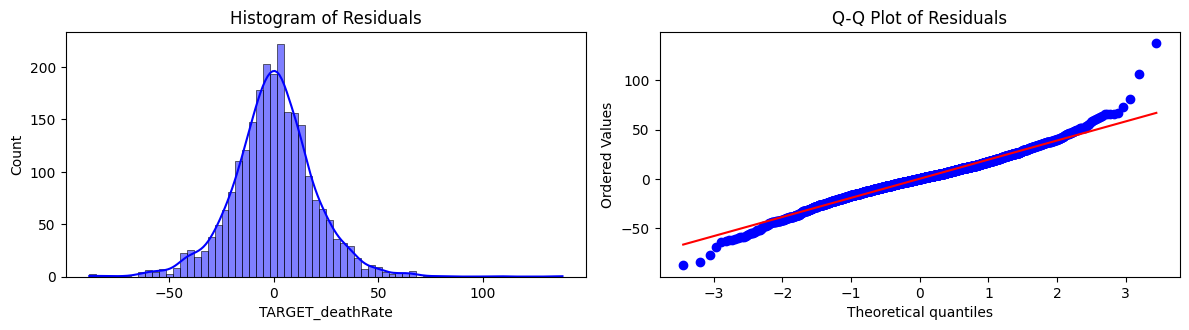

In [38]:
assess_normality(y_train, y_train_pred)

The model looks normally distributed but seems to be influenced by outliers
This means that there are certain datapoints where the model's predictions deviate signifiacntly from the actual values. 

The outliers means that the model has some bias i.e it consistently underestimates and overestimates certain types of observations. 
This could be due to the outlier capping.

I also read somewhere that if an important predictor is missing from the model, it may struggle to accurately predict outcomes in certain cases leading to outliers in the residuals. 

There could also still be some anomalies in the data

In [39]:
from functions import plot_residuals_vs_fitted

Let's test the Homoscedasticity assumption, 

Homoskedaciticity means same_variance. 
We expect teh error term to be the same across different values of the independent variables.
There should be no discernable pattern

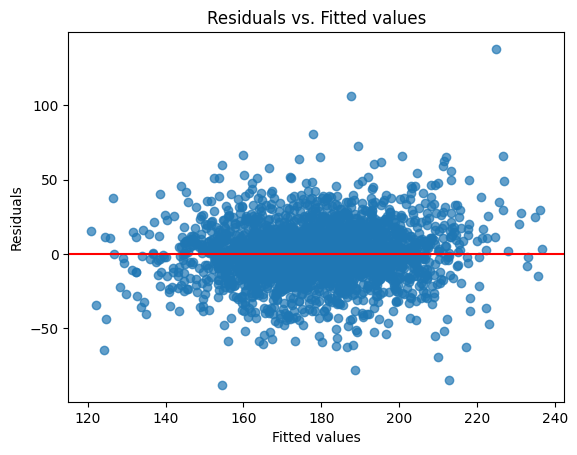

In [40]:
plot_residuals_vs_fitted(y_train, y_train_pred)

There are some outliers in the residuals. The variance is not the same across different values. 

In [ ]:
# Get the predictions on the training set
y_train_pred = lasso_pipeline.predict(X_train)

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# error metrics for linear regression
def error_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    print(f"mae: {mae}")
    print(f"rmse: {rmse}")
    print(f"R2 score {rmse}")

In [42]:
error_metrics(y_train, y_train_pred)

mae: 14.607777737590995
rmse: 19.60877682776236
R2 score 19.60877682776236


The absolute error is 14, teh squared error is 19. 
The squared error matters more in this context. We need to penalize very large errors

The R2 score is 18 meaning that the selected features only account for 18% of the variation in the dependent variable.
However it is important to note that R2 tends to increase with each additional feature
and adding additional features might be detrimental as each addition might make our model less useful in predicting data it has not seen before

In [43]:
from functions import mini_describe

In [44]:
# Get a description of the target varible
mini_describe(train, "TARGET_deathRate")

,count,mean,std,min,25%,50%,75%,max,Range,IQR
TARGET_deathRate,2437.0,178.608535,27.533371,59.7,161.7,178.6,195.1,362.8,303.1,33.4


the minimum death rate is 59.7% and our square error is 19. 
Our model seems to do well

In [45]:
# Get the coefficient and intercept
coefficients = lasso_pipeline.named_steps["lasso"].coef_
intercept = lasso_pipeline.named_steps['lasso'].intercept_

In [46]:
coefficients

array([ 0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        , 10.54312725, -0.        ,
        0.        ,  1.61320968, -0.        , -1.94771951, -0.12310095,
       -0.        ,  1.96723713,  0.        , -0.        ,  1.74319927,
       -5.96099502, -0.        ,  0.91511252, -2.2763637 , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.70431809,
        0.        , -1.28673586, -1.4509196 , -0.23579344])

In [47]:
intercept

178.60853508411984

In [48]:
# Get the selected important feature names from k best
k_best_support = lasso_pipeline.named_steps['feat_sel'].get_support()
k_best_support[:10]

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False])

In [49]:
# Get the feature names from the preprocessing pipeline
prep_feature_names = lasso_pipeline.named_steps['prep'].get_feature_names_out()
prep_feature_names[:5]

array(['cat__state_Alabama', 'cat__state_Alaska', 'cat__state_Arizona',
       'cat__state_Arkansas', 'cat__state_California'], dtype=object)

In [50]:
# Get the selected feature names from k best with pandas masking
k_best_feature_names = prep_feature_names[k_best_support]
k_best_feature_names[:5]

array(['cat__state_Alabama', 'cat__state_Alaska', 'cat__state_Arizona',
       'cat__state_Arkansas', 'cat__state_California'], dtype=object)

In [51]:
# Feature importances
feature_importances = pd.Series(coefficients, index=k_best_feature_names).sort_values(key=abs)
feature_importances.tail()

num__binnedInc             -1.947720
num__PctHS18_24             1.967237
num__PctPrivateCoverage    -2.276364
num__PctBachDeg25_Over     -5.960995
num__incidenceRate         10.543127
dtype: float64

Only 13 features are declared important by the model

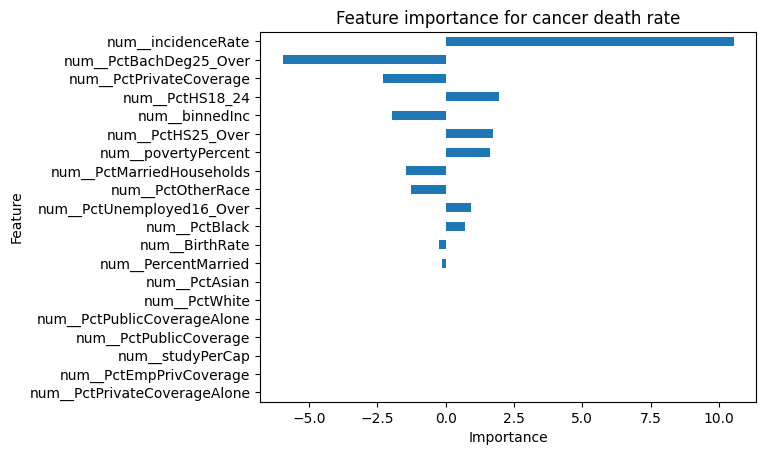

In [52]:
# Plot the feature importances
feature_importances.sort_values(key=abs).tail(20).plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature importance for cancer death rate");

In [53]:
# Test the model on the test set
test_pred = lasso_pipeline.predict(X_test)

In [54]:
# Test error
error_metrics(y_test, test_pred)

mae: 15.340210644426824
rmse: 20.477585546024574
R2 score 20.477585546024574


In [55]:
#Train error
error_metrics(y_train, y_train_pred)

mae: 14.607777737590995
rmse: 19.60877682776236
R2 score 19.60877682776236


The model is robust.

However we might need to Try out a non linear model to capture more intricate features in the dataset